Importiamo tutte le librerie che ci interessano

In [1]:
import gym
import random
import numpy as np
from keras.layers import Input, Conv2D, Dense, MaxPooling2D , Flatten
from keras.models import Model, Sequential, load_model
from collections import deque
from keras.optimizers import Adam
import keras
import matplotlib.pyplot as plt
from random import sample 

Using TensorFlow backend.


Creo l'ambiente SpaceInvaders-vo

In [2]:
env = gym.make('SpaceInvaders-v0')

Creiamo la nostra rete neurale

In [48]:
class DQN:
    def __init__(self, input_shape, output_shape, discount=0.99, update_target_every=10, memory_size=2000):
        self.input_shape=input_shape
        self.output_shape=output_shape
        self.discount=discount
        self.update_target_every=update_target_every
        self.policy_net=self.create_model()
        self.memory=deque(maxlen=memory_size)
        self.target_counter=0 
    
    def create_model(self):
        model=Sequential()
        model.add(Conv2D(input_shape=self.input_shape, filters=16, kernel_size=(8,8), strides=(4,4), padding="valid", 
                        activation="relu", use_bias=True,))
        model.add(Conv2D(filters=16, kernel_size=(4,4), strides=(2,2), padding="valid", 
                       activation="relu", use_bias=True,))
        model.add(Flatten())
        model.add(Dense(512, activation="relu"))
        model.add(Dense(self.output_shape)) 
        adm=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(loss="mse", optimizer=adm, metrics=["accuracy"] )
        return model        

Definiamo tre metodi per preprocessare la nostra immagine croppandola e portandola ad una scala di grigi

In [49]:
def to_greyscale(img):
        return np.mean(img , axis=2).astype(np.uint8)

In [50]:
def downsample(img):
        return img[::2 , ::2]

In [51]:
def crop(img):
    return img[:100 ,:]

In [52]:
def preprocess(img):
        return crop(to_greyscale(downsample(img)))/255

(100, 80)


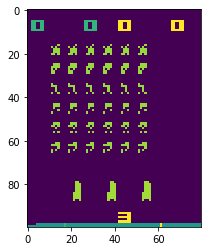

In [53]:
img = env.reset()
plt.imshow(preprocess(img))
print(preprocess(img).shape)

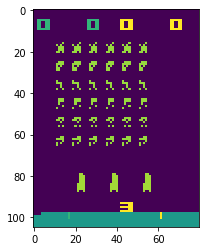

In [54]:
plt.imshow(to_greyscale(downsample(img)))

In [55]:
class Experience_Replay:
    def __init__(self , memory = [] , maxsize = 10000):
            self.iteration = 0
            self.memory = memory
            self.maxsize = maxsize
            self.experience_gain = []
            self.rmse = []
            
    def getSample(self, size_sample=32):
        choises =np.random.randint(len(mem.memory), size=size_sample )
        arr= np.array(mem.memory)
        return arr[choises , :]

In [56]:
def iteration(env  , model  , experience):
    env.reset()
    epsilon =  (0.995)**(experience.iteration)
    o,r,d,i = env.step(0)
    env.render()
    processed_state = preprocess(o)
    processed_state = processed_state.reshape((1,100,80,1))
    experience.memory = []
    exp_gain = 0
    for i in range(mem.maxsize):
        if  random.random() < epsilon:
            ac = env.action_space.sample()
        else:
            ac = np.argmax(model.policy_net.predict(processed_state))
        next_state,reward,done,info = env.step(ac)
        exp_gain= exp_gain+ reward
        if done:
            env.reset()
        env.render()
        next_processed_state = preprocess(next_state)
        next_processed_state = next_processed_state.reshape((1,100,80,1))
        experience.memory.append((processed_state,ac  , next_processed_state , reward, done))
        processed_state=next_processed_state
    experience.iteration=mem.iteration+1 
    experience.experience_gain.append(exp_gain)

In [57]:
def preprocess_experience_replay(experience_replay):
    #experience_replay= experience_replay[44:]
    length = len(experience_replay)-1
    new_experience_replay = []
    i=0
    while i < length:
        x1=(experience_replay[i])
        x2=(experience_replay[i+1])
        x3 = [np.maximum(x1[0], x2[0]) , x2[1] ,np.maximum(x1[2], x2[2]) , x1[3]+x2[3],x2[4]]
        new_experience_replay.append(x3)
        i=i+4
    return new_experience_replay 

In [58]:
def train ( experience , model,gamma = 0.99 , train_iteration=20):
    experience.memory = preprocess_experience_replay(experience.memory)
    for i in range(train_iteration):
        batch = mem.getSample()
        for state , action , next_state , reward ,done in batch:
            target =model.policy_net.predict(state)[0]
            if not done:
                target[action]= reward + gamma* np.max(model.policy_net.predict(next_state)[0])
            else:
                target[action]= 0
            target =target.reshape(1,6)
            model.policy_net.fit(state , target , verbose=0)
            prediction = model.policy_net.predict(state)
            experience.rmse.append(np.sqrt(np.mean((prediction-np.array(target))**2)))

In [59]:
experience = Experience_Replay(maxsize=3000)
dqn = DQN((100,80,1),6)

In [60]:
dqn.policy_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 24, 19, 16)        1040      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 8, 16)         4112      
_________________________________________________________________
flatten_5 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               721408    
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 3078      
Total params: 729,638
Trainable params: 729,638
Non-trainable params: 0
_________________________________________________________________


In [62]:
for i in range(10000):
    iteration(env,dqn,experience)
    train(experience , dqn)
    env.close()
    print(f"iterazione: {experience.iteration}\t gain:{experience.experience_gain[-1]}\t esplorazione: {(0.995)**(experience.iteration)}\t batch :{len(experience.memory)}")

iterazione: 10	 gain:580.0	 esplorazione: 0.9511101304657719	 batch :750
iterazione: 10	 gain:895.0	 esplorazione: 0.9511101304657719	 batch :750
iterazione: 10	 gain:1000.0	 esplorazione: 0.9511101304657719	 batch :750


KeyboardInterrupt: 

In [ ]:
def play_network(env , model):
    env.reset()
    o,r,d,i = env.step(0)
    env.render()
    processed_state = preprocess(o)
    processed_state = processed_state.reshape((1,100,80,1))
    for i in range(10000):
        ac = np.argmax(model.policy_net.predict(processed_state))
        next_state,reward,done,info = env.step(ac)
        if done:
            break
        env.render() 

In [ ]:
play_network(env , dqn)

In [24]:
env.close()

In [ ]:
#salviamo la rete
dqn.policy_net.save("modello_prova.h5")